A canonical way of importing the `bulbea` module is as follows:

In [1]:
import bulbea as bb

In [2]:
from coinmarketcap_draw import coinmarketcap_data

Go ahead and create a `Share` object as follows:

In [3]:
coin_name = 'bitcoin-cash'
data = coinmarketcap_data(coin_name)

In [4]:
nsamples = 10
data.tail(nsamples)

,market_cap,price_btc,price_usd,volume_usd,volume_token,Close
2017-12-06 00:14:00,2.516115e+10,0.127325,1494.14,1.032860e+09,691273.910075,1494.14
2017-12-06 02:14:00,2.501638e+10,0.124247,1485.53,1.075040e+09,723674.378841,1485.53
2017-12-06 04:14:00,2.554348e+10,0.124056,1516.82,1.161310e+09,765621.497607,1516.82
2017-12-06 06:14:00,2.518450e+10,0.120830,1495.49,1.179640e+09,788798.320283,1495.49
2017-12-06 08:14:00,2.508546e+10,0.120096,1489.60,1.181580e+09,793219.656284,1489.60
2017-12-06 10:14:00,2.498803e+10,0.117492,1483.80,1.072390e+09,722732.174147,1483.80
2017-12-06 12:14:00,2.491726e+10,0.116911,1479.59,1.072610e+09,724937.313715,1479.59
2017-12-06 14:14:00,2.476860e+10,0.115715,1470.74,1.028480e+09,699294.232835,1470.74
2017-12-06 16:14:00,2.473810e+10,0.117110,1468.91,1.008370e+09,686475.005276,1468.91
2017-12-06 16:54:00,2.544355e+10,0.119543,1510.79,1.030710e+09,682232.474401,1510.79


In order to analyse a given attribute, you could plot the same as follows:

##  Convert the data to hourly

In [11]:
from datetime import timedelta
import pandas as pd

def convert_with_n_hour_gap(data,n):
    times = data.index.copy()
    first_time = times[0].to_datetime()
    v_dict = dict()
    
    for x in range(1,len(times)):
        t = times[x].to_datetime()
        if n == 24:
            success = t.day == first_time.day + 1
        else:
            success = (first_time + timedelta(hours=n)).hour == t.hour
        if success:
            first_time = t
            index = pd.Timestamp(t)
            v_dict[index] = data.loc[index]['Close']
    df = pd.DataFrame(list(v_dict.items()), columns=['Date', 'Close'])
    df.set_index("Date",inplace=True)
    return df

In [12]:
share_array = []
for i in range(1,25):
    df = convert_with_n_hour_gap(data,i)
    share = bb.Share("123",'123',data=df)
    share_array.append(share)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


## visualize the 24 hour data

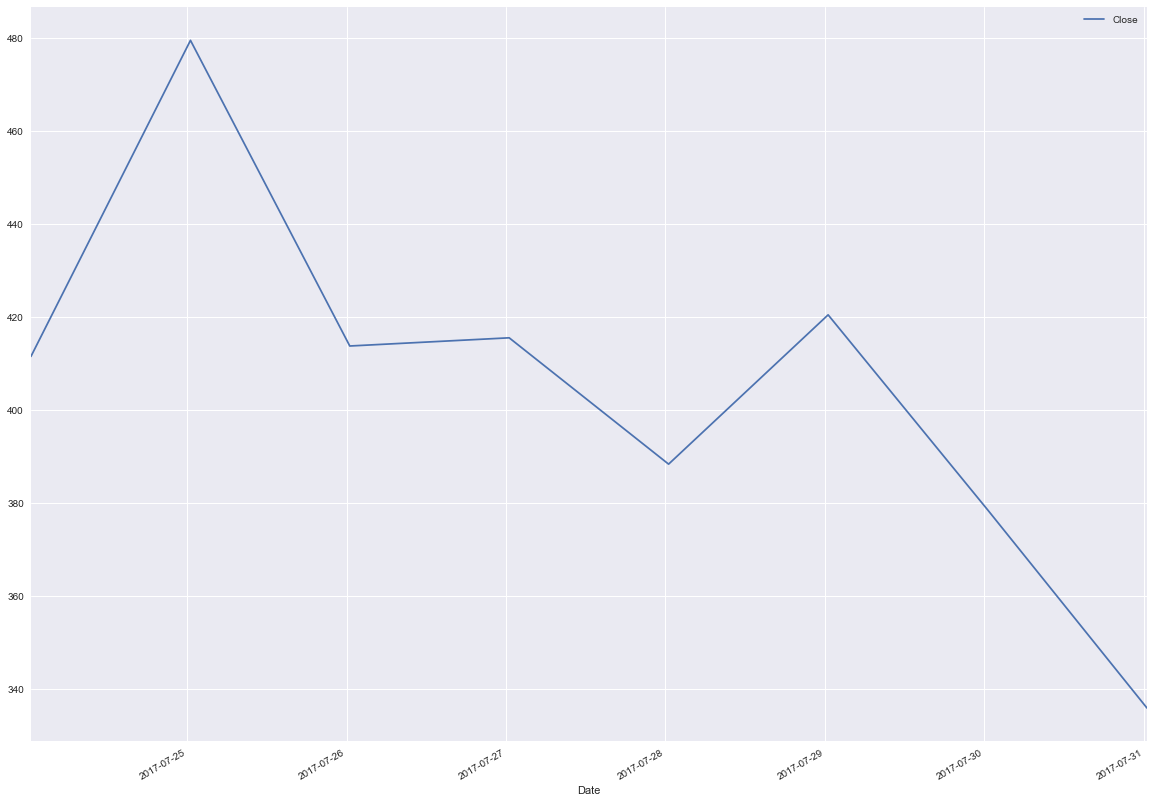

In [13]:
% matplotlib inline
share_array[-1].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

## visualize the 1 hour data

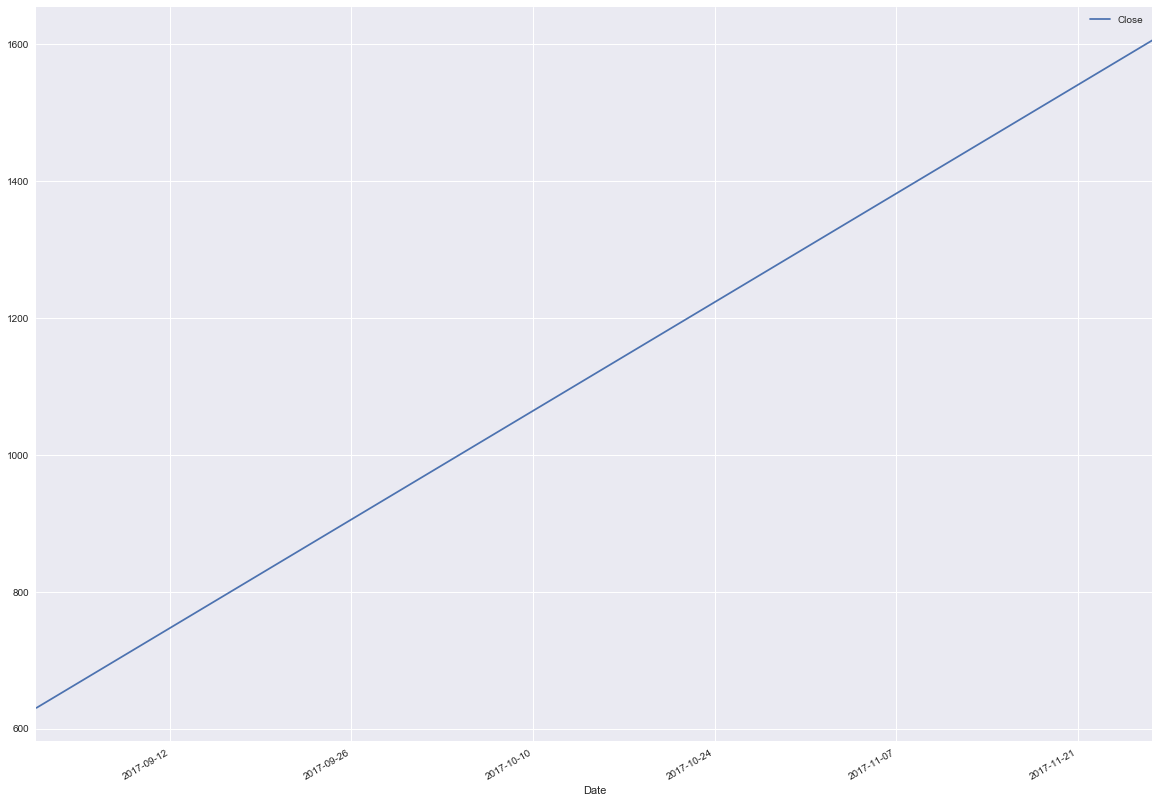

In [14]:
% matplotlib inline
share_array[0].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

### Modelling

In [15]:
from bulbea.learn.models import RNN

Using TensorFlow backend.


### Training & Testing

In [16]:
from bulbea.learn.evaluation import split
import numpy as np

In [20]:
rnn_arr = dict()
for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    if len(share.data) < 5: continue
    print(share.data.tail(5))
    Xtrain, _, ytrain, _ = split(share, 'Close', normalize = True, train=0.8)
    Xtrain  = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    
    # Training
    rnn = RNN([1, 100, 100, 1]) # number of neurons in each layer
    rnn.fit(Xtrain, ytrain, epochs=50)
    rnn_arr[index] = rnn
    

1 hour. 2
2 hour. 588
                       Close
Date                        
2017-12-06 08:14:00  1489.60
2017-12-06 10:14:00  1483.80
2017-12-06 12:14:00  1479.59
2017-12-06 14:14:00  1470.74
2017-12-06 16:14:00  1468.91
6 582


/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))


Epoch 1/50
466/466 [==============================] - 3s - loss: 0.0272      
Epoch 2/50
466/466 [==============================] - 0s - loss: 0.0227     

#### TESTING

1 hour. 2
2 hour. 588
                       Close
Date                        
2017-12-06 08:14:00  1489.60
2017-12-06 10:14:00  1483.80
2017-12-06 12:14:00  1479.59
2017-12-06 14:14:00  1470.74
2017-12-06 16:14:00  1468.91
6 582
0.0181202900224
6 582


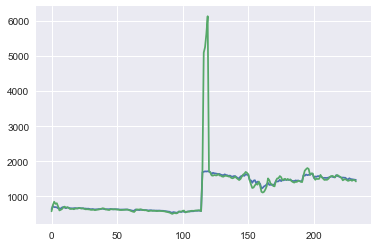

3 hour. 2
4 hour. 294
                       Close
Date                        
2017-12-06 00:14:00  1494.14
2017-12-06 04:14:00  1516.82
2017-12-06 08:14:00  1489.60
2017-12-06 12:14:00  1479.59
2017-12-06 16:14:00  1468.91
3 291
0.0318439544606
3 291


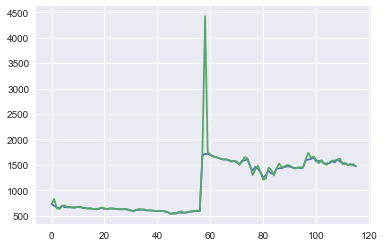

5 hour. 4
6 hour. 196
                       Close
Date                        
2017-12-05 16:14:00  1530.03
2017-12-05 22:14:00  1531.67
2017-12-06 04:14:00  1516.82
2017-12-06 10:14:00  1483.80
2017-12-06 16:14:00  1468.91
2 194
0.0466479323954
2 194


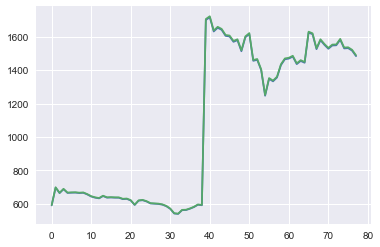

7 hour. 2
8 hour. 147
                       Close
Date                        
2017-12-05 08:14:00  1607.40
2017-12-05 16:14:00  1530.03
2017-12-06 00:14:00  1494.14
2017-12-06 08:14:00  1489.60
2017-12-06 16:14:00  1468.91
2 145
0.0646094344755
2 145


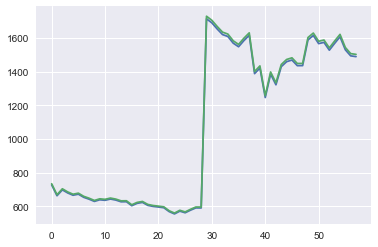

9 hour. 2
10 hour. 117
                       Close
Date                        
2017-12-04 18:14:00  1525.48
2017-12-05 04:14:00  1548.76
2017-12-05 14:14:00  1552.50
2017-12-06 00:14:00  1494.14
2017-12-06 10:14:00  1483.80
2 115
0.0757019015251
2 115


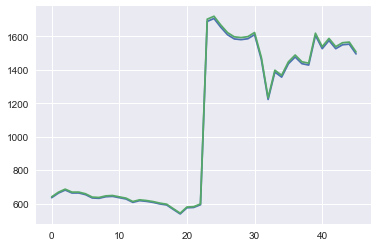

11 hour. 2
12 hour. 98
                       Close
Date                        
2017-12-04 16:14:00  1527.91
2017-12-05 04:14:00  1548.76
2017-12-05 16:14:00  1530.03
2017-12-06 04:14:00  1516.82
2017-12-06 16:14:00  1468.91
2 96
0.0971705683565
2 96


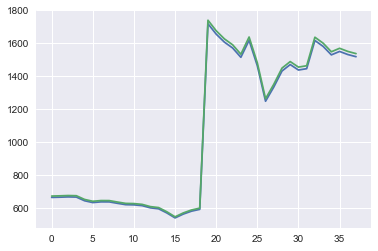

13 hour. 2
14 hour. 84
                       Close
Date                        
2017-12-04 08:14:00  1574.15
2017-12-04 22:14:00  1547.75
2017-12-05 12:14:00  1567.27
2017-12-06 02:14:00  1485.53
2017-12-06 16:14:00  1468.91
2 82
0.109345156413
2 82


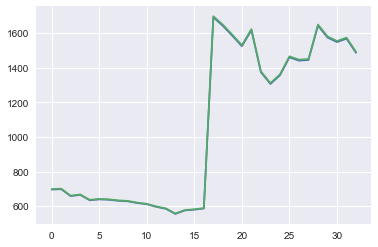

15 hour. 2
16 hour. 73
                       Close
Date                        
2017-12-03 16:14:00  1615.11
2017-12-04 08:14:00  1574.15
2017-12-05 00:14:00  1568.59
2017-12-05 16:14:00  1530.03
2017-12-06 08:14:00  1489.60
2 71
0.130027151674
2 71


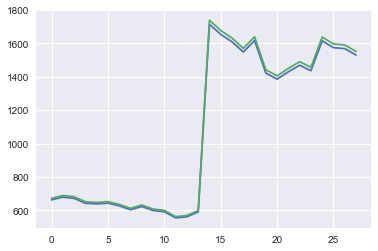

17 hour. 4
18 hour. 65
                       Close
Date                        
2017-12-03 10:14:00  1624.84
2017-12-04 04:14:00  1579.39
2017-12-04 22:14:00  1547.75
2017-12-05 16:14:00  1530.03
2017-12-06 10:14:00  1483.80
2 63
0.12537703579
2 63


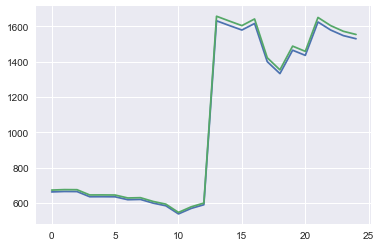

19 hour. 2
20 hour. 58
                       Close
Date                        
2017-12-02 16:14:00  1435.93
2017-12-03 12:14:00  1605.23
2017-12-04 08:14:00  1574.15
2017-12-05 04:14:00  1548.76
2017-12-06 00:14:00  1494.14
2 56
0.167917544029
2 56


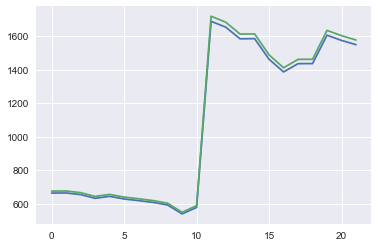

21 hour. 2
22 hour. 54
                       Close
Date                        
2017-12-02 12:14:00  1446.06
2017-12-03 10:14:00  1624.84
2017-12-04 08:14:00  1574.15
2017-12-05 06:14:00  1542.46
2017-12-06 04:14:00  1516.82
2 52
0.393573903099
2 52


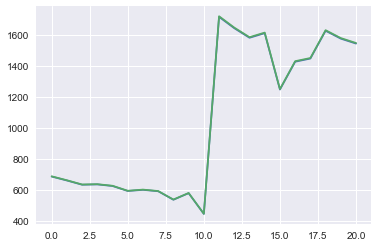

23 hour. 2
24 hour. 8
                       Close
Date                        
2017-07-27 00:29:00  415.555
2017-07-28 00:29:00  388.375
2017-07-29 00:30:00  420.495
2017-07-30 00:30:00  378.565
2017-07-31 00:30:00  335.903
2 6
0.00862418157965
2 6


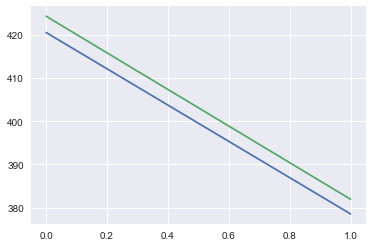

In [21]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return
from datetime import datetime

for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    if len(share.data) < 5: continue
    print(share.data.tail(5))
    _, Xtest, _, ytest = split(share, 'Close', normalize = True)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
    rnn = rnn_arr[index]
    predicted = rnn.predict(Xtest)
    sqr_err = mean_squared_error(ytest, predicted)
    print(sqr_err)
    
    
    _,_,_,ori_ytest = split(share, 'Close', normalize = False)
    
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))

    pplt.plot(ori_ytest)
    pplt.plot(new_pre)
    pplt.show()

    rnn.model.save("models/{}_{}.h5".format(coin_name,index+1))